In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
table = Table.read('data/kepler_dr2_1arcsec.fits')

In [2]:
solar_twins = (table['teff_val'] < 5800) & (table['teff_val'] > 5600)
solar_twins &= (table['radius_val'] < 1.1) & (table['radius_val'] > 0.9)
solar_twins &= table['phot_g_mean_mag'] < 13

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [3]:
np.count_nonzero(solar_twins)

353

In [76]:
kics = list(table[solar_twins]['kepid'])

In [5]:
from gatspy.periodic import LombScargleFast

In [33]:
class LightCurve(object):
    def __init__(self, times, fluxes, prot, skews=None, kurts=None, kic=None, stds=None):
        self.times = times
        self.fluxes = fluxes
        self.prot = prot
        self.kic = kic
        self.skews = skews
        self.kurts = kurts
        self.stds = stds

In [98]:
import kplr
client = kplr.API()

from scipy.ndimage import median_filter
from scipy.stats import kurtosis
lightcurves = []

from tqdm import tqdm

for kic in tqdm(kics):
    koi = client.star(kic)

    # Get a list of light curve datasets.
    lcs = koi.get_light_curves(short_cadence=False)

    # Loop over the datasets and read in the data.
    times, fluxes, kurts, stds = [], [], [], []
    for lc in lcs:
        with lc.open() as f:
            # The lightcurve data are in the first FITS HDU.
            hdu_data = f[1].data
            t = hdu_data["time"]
            flux = hdu_data["pdcsap_flux"]
            not_nan = np.logical_not(np.isnan(flux)) & np.logical_not(np.isnan(t))
            times.append(t[not_nan])
            
            fluxfit = np.polyval(np.polyfit(t[not_nan]-t[not_nan].mean(), flux[not_nan], 1), 
                                 t[not_nan]-t[not_nan].mean())
            detrended_flux = median_filter(flux[not_nan] / fluxfit, (11,))
            fluxes.append(detrended_flux)
            
            kurts.append(kurtosis(detrended_flux, fisher=False))
            stds.append(np.std(detrended_flux))
            
#     plt.plot(np.concatenate(times), np.concatenate(fluxes))
#     plt.show()

    m = LombScargleFast(optimizer_kwds={'quiet': True})
    m.optimizer.period_range = (1, 30)
    m.fit(np.concatenate(times), np.concatenate(fluxes))
    
    lightcurves.append(LightCurve(np.concatenate(times), np.concatenate(fluxes), m.best_period, 
                                  kurts=kurts, stds=stds, kic=kic))

100%|██████████| 353/353 [13:20<00:00,  1.94s/it]


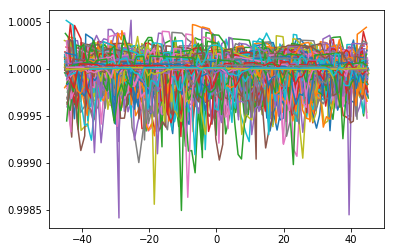

In [89]:
from astropy.time import Time
lc = np.load('mrspoc_lc.npy')
times = lc[:, 0]
fluxes = lc[:, 1]

julian_date_ints = Time(times, format='jd').jd.astype(int)
jd_min = np.min(julian_date_ints)
jd_max = np.max(julian_date_ints)
missing_dates = set(np.arange(jd_min, jd_max)).difference(julian_date_ints)

all_dates = np.concatenate([Time(times, format='jd').jd, list(missing_dates)])
all_fluxes = np.concatenate([fluxes, np.ones(len(missing_dates))])

sort = np.argsort(all_dates)

all_dates = all_dates[sort]
all_fluxes = all_fluxes[sort]

solar_times = []
solar_fluxes = []
skews = []
kurts = []
for i in np.arange(0, len(times), 90): 
    t = all_dates[i:i+90] - all_dates[i:i+90].mean()
    f = all_fluxes[i:i+90] / np.median(all_fluxes[i:i+90])
    f /= np.polyval(np.polyfit(t, f, 3), t)
    plt.plot(t, f)
    
    solar_times.append(t)
    solar_fluxes.append(f)
#     skews.append(skew(filt(f)))
    kurts.append(kurtosis(median_filter(f, 11), fisher=False))
    
solar_lc = LightCurve(np.concatenate(solar_times), np.concatenate(solar_fluxes), 26.3,#, skews=skews, 
                      kurts=kurts)

In [9]:
# from scipy.stats import skew, kurtosis
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# skews = []
# kurts = []
# rots = []
# for i, lc in enumerate(lightcurves):
#     ax[0].plot(lc.times, lc.fluxes + 0.004*i, color='k', lw=0.5)
#     skews.append(skew(lc.fluxes))
#     kurts.append(kurtosis(lc.fluxes))
#     rots.append(lc.prot)

# cax = ax[1].scatter(skews, kurts, c=rots, vmin=15, vmax=30)    
# ax[1].set_yscale('log')
# cbar = plt.colorbar(cax)
# cbar.set_label('$P_\mathrm{rot}$', fontsize=15)

# ax[1].set_xscale('symlog')

# ax[1].scatter(skew(solar_lc.fluxes), kurtosis(solar_lc.fluxes), marker='$\odot$', s=200, 
#               c=cbar.to_rgba(solar_lc.prot))

# ax[0].set(xlabel='Time [d]', ylabel='Flux')

# ax[1].set(xlabel='Skew', ylabel='Kurtosis')

# ax[1].annotate("Spots", xy=(-0.5, 1100), ha='right')
# ax[1].axvline(0, color='k', ls='--')
# ax[1].annotate("Flares/faculae", xy=(0.5, 1100), ha='left')
# fig.tight_layout()
# fig.savefig('paper_plots/stats.pdf', bbox_inches='tight')

In [10]:
# from scipy.stats import skew, kurtosis
# fig, ax = plt.subplots(figsize=(4, 3))

# from astropy.stats import sigma_clip, mad_std

# def filt(x): 
#     return median_filter(x, (11,))

# skews = []
# kurts = []
# rots = []
# for i, lc in enumerate(lightcurves):
# #     ax[0].plot(lc.times, lc.fluxes + 0.004*i, color='k', lw=0.5)

#     #fluxes = sigma_clip(lc.fluxes, sigma=4, cenfunc=mad_std)

#     skews.append(skew(filt(lc.fluxes)))
#     kurts.append(kurtosis(filt(lc.fluxes), fisher=False))
#     rots.append(lc.prot)

# cax = ax.scatter(skews, kurts, c=rots, vmin=5, vmax=25, s=10)    
# ax.set_yscale('log')
# cbar = plt.colorbar(cax)
# cbar.set_label('$P_\mathrm{rot}$', fontsize=15)

# ax.set_xscale('symlog')

# ax.scatter(skew(solar_lc.fluxes), kurtosis(solar_lc.fluxes, fisher=False), marker='$\odot$', s=200, 
#            c=cbar.to_rgba(solar_lc.prot))

# # ax[0].set(xlabel='Time [d]', ylabel='Flux')

# ax.set(xlabel='Skewness', ylabel='Kurtosis', xlim=[-10, 0.5], ylim=[0, 30])
# ax.grid(ls=":")
# # ax.annotate("Dimmer", xy=(-0.5, 1000), ha='right')
# ax.axvline(0, color='silver', ls='--')
# # ax.annotate("Brighter", xy=(0.5, 1000), ha='left')
# fig.tight_layout()
# fig.savefig('paper_plots/stats.pdf', bbox_inches='tight')

In [11]:
# from astropy.stats import mad_std

# fig, ax = plt.subplots(figsize=(4, 3))

# skews = []
# stds = []
# rots = []
# for i, lc in enumerate(lightcurves):
# #     ax[0].plot(lc.times, lc.fluxes + 0.004*i, color='k', lw=0.5)
#     skews.append(skew(filt(lc.fluxes)))
#     stds.append(np.std(filt(lc.fluxes)))
#     rots.append(lc.prot)

# cax = ax.scatter(stds, skews, c=rots, vmin=5, vmax=25, s=10)    
# ax.set_yscale('symlog')
# cbar = plt.colorbar(cax)
# cbar.set_label('$P_\mathrm{rot}$', fontsize=15)

# ax.set_xscale('log')

# ax.scatter(np.std(solar_lc.fluxes), skew(solar_lc.fluxes), marker='$\odot$', s=200, 
#            c=cbar.to_rgba(solar_lc.prot))

# # ax[0].set(xlabel='Time [d]', ylabel='Flux')

# ax.set(ylabel='Skewness', xlabel='$\sigma$', xlim=[2e-5, 1e-2], ylim=[-10, 3])
# ax.grid(ls=':')
# # ax.annotate("Spots", xy=(-0.5, 1100), ha='right')
# # ax.axhline(0, color='k', ls='--')
# # ax.annotate("Flares/faculae", xy=(0.5, 1100), ha='left')
# fig.tight_layout()
# fig.savefig('paper_plots/stats_skew_std.pdf', bbox_inches='tight')

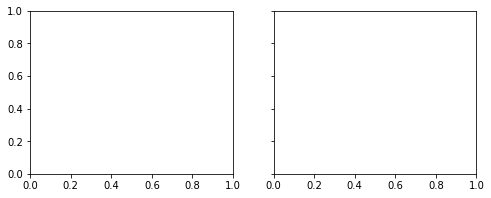

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
cmap = plt.cm.viridis_r

skews = []
kurts = []
rots = []
stds = []
kics = []
for i, lc in enumerate(lightcurves):
#     skews.append(skew(filt(lc.fluxes)))
#     kurts.append(kurtosis(filt(lc.fluxes), fisher=False))
    kics.append(lc.kic)
#     skews.append(np.median(lc.skews))
    kurts.append(np.median(lc.kurts))

    rots.append(lc.prot)
    stds.append(np.std(lc.fluxes))
#     stds.append(np.median(lc.stds))

# cax = ax[0].scatter(stds, skews, c=rots, vmin=5, vmax=30, s=10, cmap=cmap)    
# # ax[0].set_yscale('symlog')
# # cbar = plt.colorbar(cax)
# # cbar.set_label('$P_\mathrm{rot}$', fontsize=15)

# ax[0].set_xscale('log')


# ax[0].set(xlabel='Standard Deviation', ylabel='Skewness', xlim=[1e-5, 1e-2])#, ylim=[-10, 3])
# ax[0].grid(ls=':')

# # cax = ax[1].scatter(kurts, skews, c=rots, vmin=5, vmax=30, s=10, cmap=cmap)    
# # ax[1].set_xscale('log')
# cbar = plt.colorbar(cax)
# cbar.set_label('$P_\mathrm{rot}$ [d]', fontsize=15)

# ax[0].scatter(np.std(solar_lc.fluxes), np.median(solar_lc.skews), marker='$\odot$', s=200, 
#                c=cbar.to_rgba(solar_lc.prot), cmap=cmap)

# # ax[1].set_yscale('symlog')

# ax[1].scatter(np.median(solar_lc.kurts), np.median(solar_lc.skews), marker='$\odot$', s=200, 
#               c=cbar.to_rgba(solar_lc.prot), cmap=cmap)
# ax[1].set(xlabel='Kurtosis')#, ylim=[-10, 0.5], xlim=[-1, 30])
# ax[1].grid(ls=":")
# ax[1].axvline(0, color='silver', ls='--')

# fig.tight_layout()
# fig.savefig('paper_plots/stats.pdf', bbox_inches='tight')

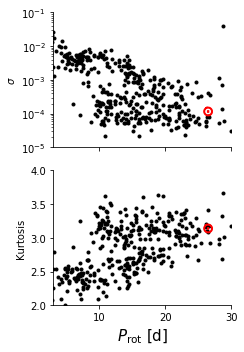

In [101]:
fig, ax = plt.subplots(2,1, figsize=(3.5, 5), sharex=True)
ax[0].scatter(rots, stds, marker='.', color='k')
ax[0].scatter(26.3, np.std(solar_lc.fluxes), marker='$\odot$', s=100, zorder=10, color='r')
ax[0].set_yscale('log')
ax[0].set_ylim([1e-5, 1e-1])

ax[1].scatter(rots, kurts, marker='.', color='k')
ax[1].scatter(26.3, np.median(solar_lc.kurts), marker='$\odot$', s=100, zorder=10, color='r')

ax[0].set(ylabel='$\sigma$')
ax[1].set(ylabel='Kurtosis', xlim=[3, 30], ylim=[2, 4])
ax[1].set_xlabel('$P_\mathrm{rot}$ [d]', fontsize=15)
for axis in ax: 
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)

fig.tight_layout()
fig.savefig('paper_plots/stats_simple.pdf')

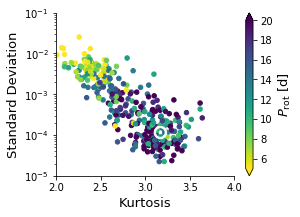

In [104]:
outlier_kics = (np.array(stds) > 1e-2) & (np.array(kurts) > 3.5)

fig = plt.figure(figsize=(4, 3))
cax = plt.scatter(np.array(kurts)[~outlier_kics], np.array(stds)[~outlier_kics], c=np.array(rots)[~outlier_kics], 
                  s=20, vmin=5, vmax=20, cmap=plt.cm.viridis_r)
fontsize = 13
cbar = plt.colorbar(cax, extend='both')
cbar.set_label('$P_\mathrm{rot}$ [d]', fontsize=fontsize)

plt.scatter(np.median(solar_lc.kurts), np.std(solar_lc.fluxes), marker='$\odot$', s=200, c='w')#cbar.to_rgba(26.3))
plt.yscale('log')
plt.xlabel('Kurtosis', fontsize=fontsize)
plt.ylabel('Standard Deviation', fontsize=fontsize)

plt.ylim([1e-5, 1e-1])
plt.xlim([2, 4])

for s in ['right', 'top']: 
    plt.gca().spines[s].set_visible(False)
fig.savefig("paper_plots/stats_std_kurtosis.pdf", bbox_inches='tight')

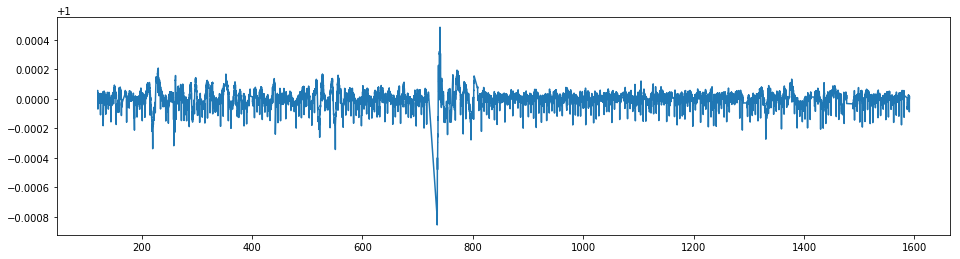

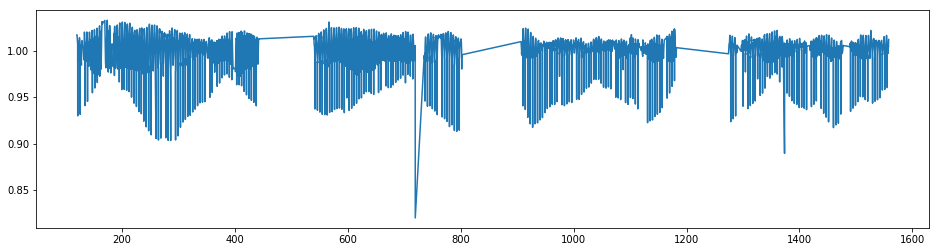

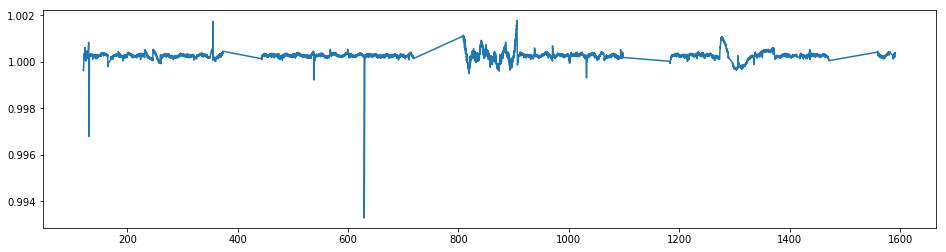

In [106]:
for kic, lc in zip(kics, lightcurves):
    if kic in np.array(kics)[np.array(kurts) > 4]:
        plt.figure(figsize=(16, 4))
#         plt.plot(lc.times[:1000], lc.fluxes[:1000])
# 
        plt.plot(lc.times, lc.fluxes)

        plt.show()

2731.238633721973

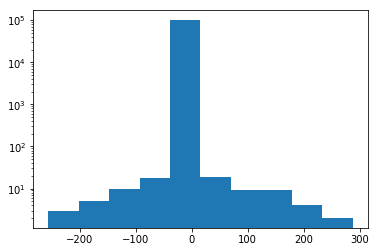

In [139]:
theta = np.linspace(0, 6*np.pi, 100000)
f = np.sin(theta)
inds = np.random.randint(0, len(theta), size=100)
f[inds] += 100*np.random.randn(100)

# plt.plot(theta, f)
plt.hist(f, log=True)
kurtosis(f, fisher=False)

[ 5343976 11805150]


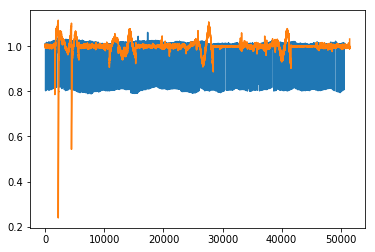

In [96]:

print(outlier_kics)
for i, lc in enumerate(lightcurves):
    if lc.kic in outlier_kics: 
       plt.plot(lc.fluxes) 

0.030303030303030304

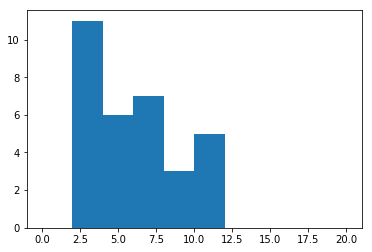

In [71]:
plt.hist(np.array(rots)[np.array(stds) > 5e-3], range=[0, 20])
np.count_nonzero(np.array(rots)[np.array(stds) > 5e-3] > 11)/len(np.array(rots)[np.array(stds) > 5e-3])

0.7846715328467153

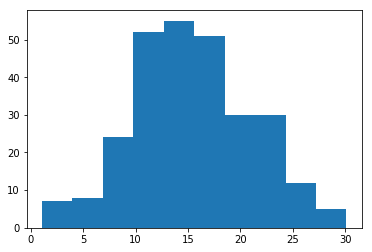

In [85]:
plt.hist(np.array(rots)[np.array(kurts) > 2.5])#, range=[0, 20])
np.count_nonzero(np.array(rots)[np.array(kurts) > 2.5] > 11)/len(np.array(rots)[np.array(kurts) > 2.5])

In [77]:
# X = np.vstack([kurts, np.log10(stds)]).T
# y = rots

# from sklearn.linear_model import LinearRegression

# m = LinearRegression()
# m.fit(X, y)

In [34]:
from sklearn.mixture import GMM

# X = np.array([kurts, np.log(stds), rots]).T
X = np.array([kurts, np.log10(stds)]).T


gmm = GMM(n_components=2)
gmm.fit(X)

# k = KMeans(n_clusters=3)
# k.fit(X)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [35]:
colors = gmm.predict(X)

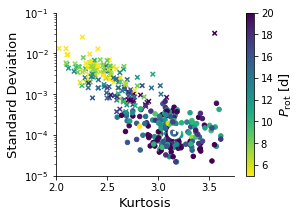

In [36]:
fig = plt.figure(figsize=(4, 3))

for color, shape in zip(set(colors), ['o', 'x', 's']):
    cond = color == colors
    
    cax = plt.scatter(np.array(kurts)[cond], np.array(stds)[cond], c=np.array(rots)[cond], 
                      s=20, vmin=5, vmax=20, cmap=plt.cm.viridis_r, 
                      marker=shape)
    fontsize = 13
cbar = plt.colorbar(cax)
cbar.set_label('$P_\mathrm{rot}$ [d]', fontsize=fontsize)

plt.scatter(np.median(solar_lc.kurts), np.std(solar_lc.fluxes), marker='$\odot$', s=200, c='w')#cbar.to_rgba(26.3))
plt.yscale('log')
plt.xlabel('Kurtosis', fontsize=fontsize)
plt.ylabel('Standard Deviation', fontsize=fontsize)

plt.ylim([1e-5, 1e-1])
plt.xlim([2, 3.75])

for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
#     fig.savefig("paper_plots/stats_std_kurtosis.pdf", bbox_inches='tight')

In [188]:
hits = 0
dstep = 1/12
steps = np.arange(1917, 1985, dstep)
for i in steps: 
    inrange = (Time(all_dates, format='jd').decimalyear < i+dstep) & (Time(all_dates, format='jd').decimalyear >= i)
    t = all_dates[inrange]
    f = all_fluxes[inrange]
    
    if gmm.predict([[np.std(f), kurtosis(f)]]) == 1: 
        hits += 1
hits/len(steps)

0.6629901960784313

In [2]:
for i, lc in enumerate(lightcurves):
    if abs(np.median(lc.kurts) - 2) < 0.05:
        fig, ax = plt.subplots(2, 2, figsize=(8, 5), sharey=True)
        print(lc.kic)
        ax[0, 0].set_title("KIC "+str(lc.kic))
        ax[0, 0].plot(lc.times, filt(lc.fluxes), color='k', lw=0.5)
        ax[0, 0].set(xlabel='Days', ylabel='Flux')
        ax[0, 1].hist(filt(lc.fluxes), color='k',
                   histtype='stepfilled', orientation='horizontal')
        #ax[0, 1].set_aspect(50000)
        
plotted = False
for i, lc in enumerate(lightcurves):
    if abs(np.median(lc.kurts) - 3.0) < 0.05 and not plotted:
#         fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
        print(lc.kic)
        ax[1, 0].set_title("KIC "+str(lc.kic))
        ax[1, 0].plot(lc.times, filt(lc.fluxes), color='k', lw=0.5)
        ax[1, 0].set(xlabel='Days', ylabel='Flux')
        ax[1, 1].hist(filt(lc.fluxes), color='k',
                   histtype='stepfilled', orientation='horizontal')
        #ax[1, 1].set_aspect(500000)
        plotted = True
        
#         ax[1].set_xlabel('Flux')
#         ax[1].set_yticks([])
fig.tight_layout()
        

NameError: name 'lightcurves' is not defined

7747867


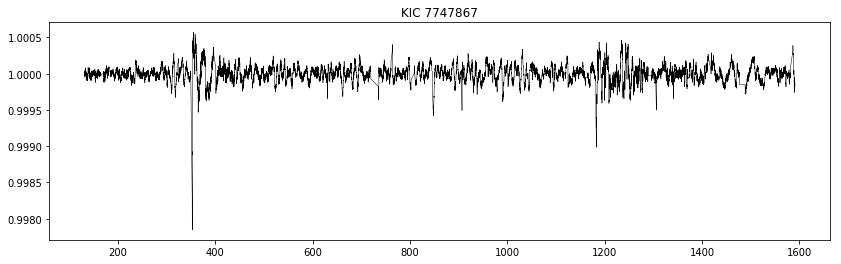

In [43]:
for i, lc in enumerate(lightcurves):
#     ax[0].plot(lc.times, lc.fluxes + 0.004*i, color='k', lw=0.5)
#     if skew(lc.fluxes) < -1 and np.std(filt(lc.fluxes)) > 1e-4:  # np.mean(lc.skews) < -2 

    if abs(np.median(lc.kurts) - 3.75) < 0.1:#  and abs(np.median(lc.skews) - -0.5) < 0.5:   # np.mean(lc.skews) < -2 
        plt.figure(figsize=(14, 4))
        print(lc.kic)
        plt.title("KIC "+str(lc.kic))
        plt.plot(lc.times, filt(lc.fluxes), color='k', lw=0.5)

4661879
6049083
8226498
8394475
10487156
11180130


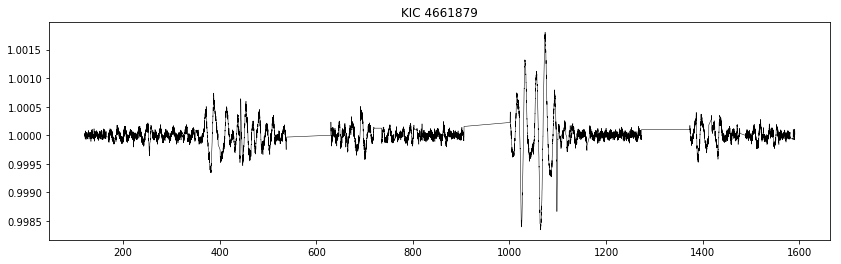

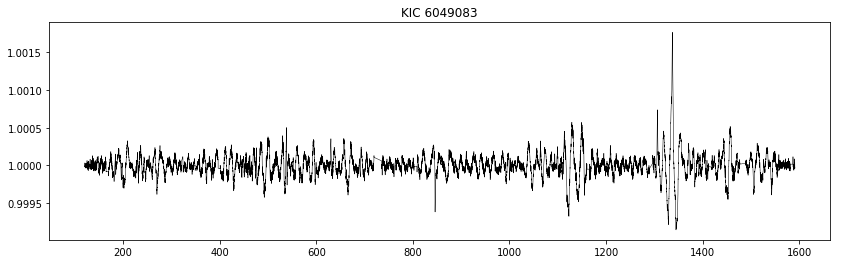

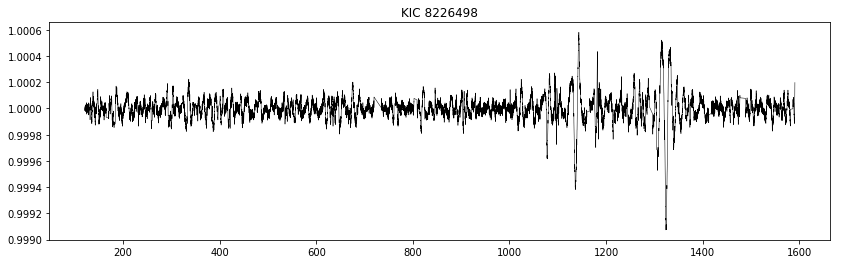

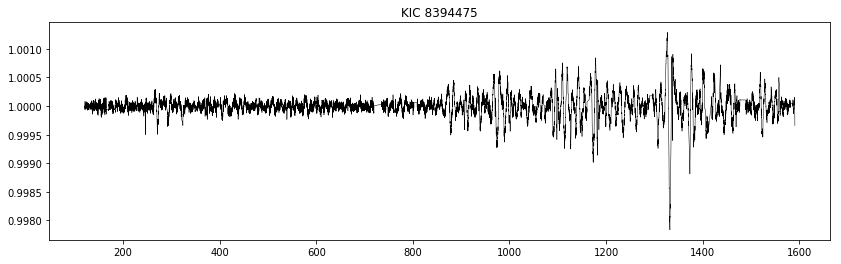

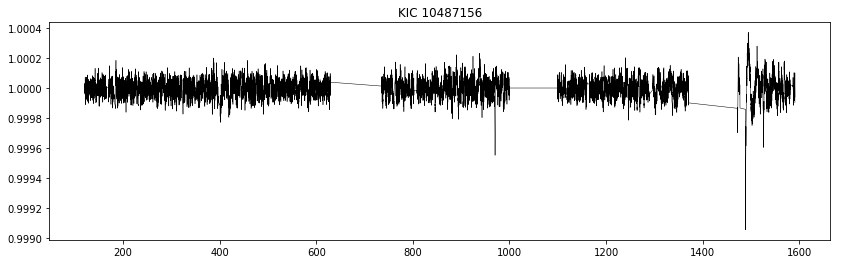

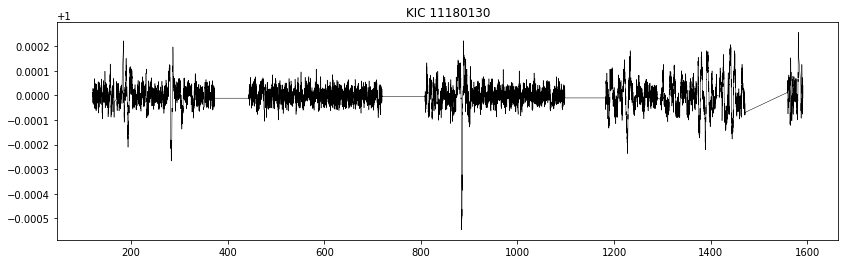

In [107]:
for i, lc in enumerate(lightcurves):
#     ax[0].plot(lc.times, lc.fluxes + 0.004*i, color='k', lw=0.5)
    if kurtosis(filt(lc.fluxes), fisher=False) > 15 and kurtosis(filt(lc.fluxes), fisher=False) < 20: # and skew(filt(lc.fluxes)) < 0:
        plt.figure(figsize=(14, 4))
        print(lc.epic)
        plt.title("KIC "+str(lc.epic))
        plt.plot(lc.times, filt(lc.fluxes), color='k', lw=0.5)
        
#         plt.xlim([644, 645])